## 1. Setup

### 1.1 Install Dependencies

In [1]:
!pip install tensorflow==2.9.0 tensorflow-gpu==2.9.0 opencv-python matplotlib

^C


### 1.2 Import Dependencies

In [44]:
# Import standard dependencies
import cv2
import os   
import random
import numpy as np
from matplotlib import pyplot as plt

In [45]:
# Import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

### 1.3 Set GPU Growth

In [46]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [47]:
gpus

[]

### 1.4 Create Folder Structures

In [48]:
# Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [49]:
# Make the directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

FileExistsError: [WinError 183] Impossible de créer un fichier déjà existant: 'data\\positive'

## 2. Collect Positives and Anchors

### 2.1 Untar Labelled Faces in the Wild Dataset

In [ ]:
# Uncompress Tar GZ Labelled Faces in the Wild Dataset
!tar -xf lfw.tgz

tar: Error opening archive: Failed to open 'lfw.tgz'


In [7]:
# Move LFW Images to the following repository data/negative
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

NotADirectoryError: [WinError 267] Nom de répertoire non valide: 'lfw\\Aaron_Eckhart_0001.jpg'

### 2.2 Collect Positive and Anchor Classes

In [8]:
# Import uuid library to generate unique image names
import uuid


In [9]:
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

'data\\anchor\\875de14a-2cdb-11ef-98da-0c9a3c16cb2c.jpg'

In [9]:
# Establish a connection to the webcam
cap = cv2.VideoCapture(0)
# Set the resolution to 1280x720
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1280)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)

# Set timer interval (in seconds)
import time 
interval = 0.2
last_saved_time = time.time()


while cap.isOpened(): 
    ret, frame = cap.read()
   
    # Modify frame slicing to capture the entire webcam view
    frame = frame[0:720, 0:1280, :]

    
    # Save screenshot every 0.5 seconds
    if time.time() - last_saved_time >= interval:
        # Create the unique file path 
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)
        last_saved_time = time.time()
    """
     if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create the unique file path 
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname, frame)
    
     # Collect positives
    if cv2.waitKey(1) & 0XFF == ord('n'):
        # Create the unique file path 
        imgname = os.path.join(NEG_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out positive imageq
        cv2.imwrite(imgname, frame)
    """
    # Collect positives
   

    # Show image back to screen
    cv2.imshow('Webcam Frame', frame)
    
    # Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

KeyboardInterrupt: 

## 3. Load and Preprocess Images

### 3.1 Get Image Directories

In [50]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(500)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(500)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(500)

In [51]:
dir_test = anchor.as_numpy_iterator()

In [52]:
print(dir_test.next())

b'data\\anchor\\face_1173.jpg'


### 3.2 Preprocessing - Scale and Resize

In [53]:
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 
    img = img / 255.0
    
    # Return image
    return img

<class 'PIL.JpegImagePlugin.JpegImageFile'>
(69, 69)


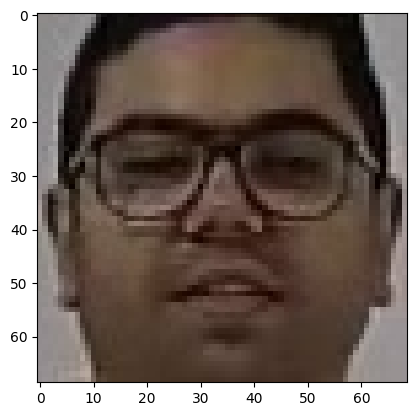

In [22]:
from PIL import Image

# Read the image file
img1 = Image.open('data/positive/face_1140.jpg')

# Check the type and size of the image
print(type(img1))
print(img1.size)
plt.imshow(img1)



In [ ]:

img = preprocess('data\\positive\\face_1140.jpg')
img

In [24]:
img.numpy().max() 

0.7119941

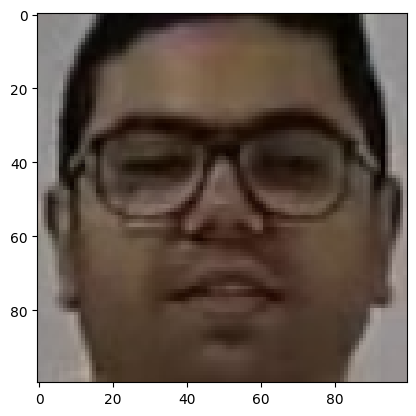

In [25]:

plt.imshow(img)

In [54]:
dataset.map(preprocess)

NameError: name 'dataset' is not defined

### 3.3 Create Labelled Dataset

In [18]:
# (anchor, positive) => 1,1,1,1,1
# (anchor, negative) => 0,0,0,0,0

In [55]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)


In [56]:
samples = data.as_numpy_iterator()

In [57]:
exampple = samples.next()

In [58]:
exampple

(b'data\\anchor\\face_1489.jpg', b'data\\positive\\face_1035.jpg', 1.0)

### 3.4 Build Train and Test Partition

In [59]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [60]:
res = preprocess_twin(*exampple)

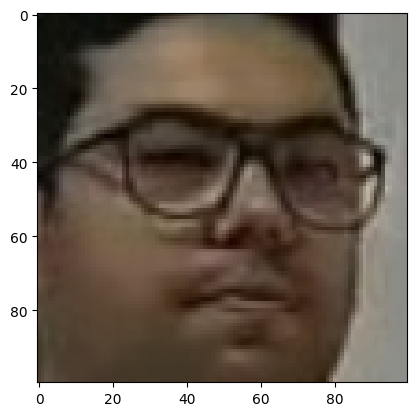

In [61]:
plt.imshow(res[1])

In [62]:
res[2]

1.0

In [63]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [64]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [65]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

## 4. Model Engineering

### 4.1 Build Embedding Layer

In [27]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')



In [28]:
embedding = make_embedding()    

In [29]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 46, 46, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       26

### 4.2 Build Distance Layer

In [66]:
# Siamese L1 Distance class
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)



In [67]:
l1 = L1Dist()

### 4.3 Make Siamese Model

In [35]:
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))

In [36]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)


In [37]:
siamese_layer = L1Dist()


In [38]:
distances = siamese_layer(inp_embedding, val_embedding)

In [39]:
classifier = Dense(1, activation='sigmoid')(distances)

In [40]:
classifier


<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_1')>

In [41]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [42]:
siamese_network.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

In [43]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')



In [44]:
siamese_model = make_siamese_model()

In [45]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

## 5. Training

### 5.1 Setup Loss and Optimizer

In [68]:
binary_cross_loss = tf.losses.BinaryCrossentropy()


In [47]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

### 5.2 Establish Checkpoints


In [48]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)


### 5.3 Build Train Step Function

In [49]:
test_batch = train_data.as_numpy_iterator()


In [51]:
batch_1 = test_batch.next()


In [52]:
X = batch_1[:2]


In [53]:
y = batch_1[2]


In [54]:
y


array([0., 1., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0.],
      dtype=float32)

In [55]:
tf.losses.BinaryCrossentropy??


Init signature:
tf.losses.BinaryCrossentropy(
    from_logits=False,
    label_smoothing=0.0,
    axis=-1,
    reduction='auto',
    name='binary_crossentropy',
)
Source:        
@keras_export('keras.losses.BinaryCrossentropy')
class BinaryCrossentropy(LossFunctionWrapper):
  """Computes the cross-entropy loss between true labels and predicted labels.

  Use this cross-entropy loss for binary (0 or 1) classification applications.
  The loss function requires the following inputs:

  - `y_true` (true label): This is either 0 or 1.
  - `y_pred` (predicted value): This is the model's prediction, i.e, a single
    floating-point value which either represents a
    [logit](https://en.wikipedia.org/wiki/Logit), (i.e, value in [-inf, inf]
    when `from_logits=True`) or a probability (i.e, value in [0., 1.] when
    `from_logits=False`).

  **Recommended Usage:** (set `from_logits=True`)

  With `tf.keras` API:

  ```python
  model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_log

In [56]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
    
    # Return loss
    return loss


### 5.4 Build Training Loop

In [57]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            train_step(batch)
            progbar.update(idx+1)
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

EPOCHS = 40

train(train_data, EPOCHS)




### 5.5 Train the model

In [58]:
EPOCHS = 40

In [59]:
train(train_data, EPOCHS)


 Epoch 1/40
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
44/44 [==============================] - 937s 21s/step

 Epoch 2/40
44/44 [==============================] - 928s 21s/step

 Epoch 3/40
44/44 [==============================] - 928s 21s/step

 Epoch 4/40
44/44 [==============================] - 926s 21s/step

 Epoch 5/40
44/44 [==============================] - 925s 21s/step

 Epoch 6/40
44/44 [==============================] - 930s 21s/step

 Epoch 7/40
44/44 [==============================] - 928s 21s/step

 Epoch 8/40
44/44 [==============================] - 913s 21s/step

 Epoch 9/40
44/44 [==============================] - 860s 20s/step

 Epoch 10/40
44/44 [==============================] - 876s 20s/step

 Epoch 11/40
44/44 [==============================] - 914s 21s/step

 Epoch 12/40
44/44 [==============================] - 918s 21s/step

 Epoch 13/40
44/44 [======

## 6. Evaluate Model


In [69]:
# Reload model
model = tf.keras.models.load_model('Adam Lassoued.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})
model.compile(optimizer='Adam', loss='BinaryCrossentropy', metrics=['accuracy'])


### 6.1 Import Metrics

In [70]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall


### 6.2 Make Predictions

In [71]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()


In [74]:
# Make predictions
y_hat = model.predict([test_input, test_val])
y_hat

1/1 [==============================] - 3s 3s/step


array([[9.9999893e-01],
       [9.9999970e-01],
       [9.9785968e-10],
       [9.9998188e-01],
       [9.9134213e-01],
       [3.9892159e-11],
       [1.0000000e+00],
       [9.4120216e-01],
       [1.0000000e+00],
       [2.0672286e-09],
       [9.9999905e-01],
       [1.0000000e+00],
       [1.0000000e+00],
       [2.5968439e-10],
       [1.0000000e+00],
       [8.4112433e-09]], dtype=float32)

In [75]:
# Post processing the results 
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0]

In [76]:
y_true


array([1., 1., 0., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 0.],
      dtype=float32)

### 6.3 Calculate Metrics


In [ ]:
# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

# Creating a metric object 
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

# Calculate F1-score
f1_score = 2 * (precision_result * recall_result) / (precision_result + recall_result)


In [ ]:
# Creating a metric object 
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

In [ ]:


# 1. Instantiate Precision and Recall metrics
precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()

# 2. Update their states with your data
precision.update_state(y_true, y_hat)
recall.update_state(y_true, y_hat)

# 3. Calculate Precision, Recall, and then F1-score
precision_result = precision.result().numpy()
recall_result = recall.result().numpy()

# Calculate F1-score
f1_score = 2 * (precision_result * recall_result) / (precision_result + recall_result)





### 6.4 Viz Results

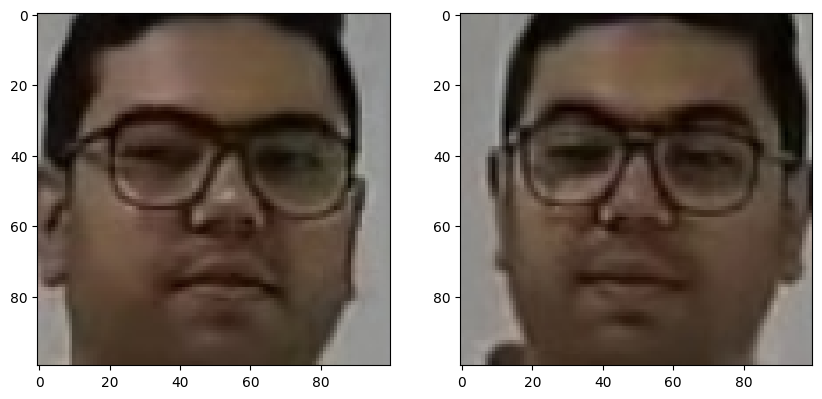

In [67]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[14])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[14])

# Renders cleanly
plt.show()

#[0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
#[0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0.],


## 7. Save Model


In [68]:

siamese_model.compile(optimizer='Adam', loss='BinaryCrossentropy', metrics=['accuracy'])
# Save weights
siamese_model.save('Adam Lassoued.h5')


In [136]:
L1Dist


__main__.L1Dist

In [6]:
# Reload model
model = tf.keras.models.load_model('Adam Lasoued.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})
model.compile(optimizer='Adam', loss='BinaryCrossentropy', metrics=['accuracy'])


NameError: name 'L1Dist' is not defined

In [138]:
# Make predictions with reloaded model
model.predict([test_input, test_val])


1/1 [==============================] - 1s 1s/step


array([[3.2688881e-08],
       [5.9259297e-10],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [9.9997342e-01],
       [9.9999887e-01],
       [9.9992633e-01],
       [4.2846700e-08],
       [9.9999994e-01],
       [9.9989980e-01],
       [9.9997813e-01],
       [9.9642697e-11],
       [1.0000000e+00],
       [4.8692172e-08],
       [1.2834101e-06]], dtype=float32)

In [139]:
# View model summary
model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

## 8. Real Time Test


### 8.1 Verification Function


In [140]:
os.listdir(os.path.join('application_data', 'verification_images'))


FileNotFoundError: [WinError 3] Le chemin d’accès spécifié est introuvable: 'application_data\\verification_images'

In [71]:
os.path.join('application_data', 'input_image', 'input_image.jpg')


'application_data\\input_image\\input_image.jpg'

In [72]:
for image in os.listdir(os.path.join('application_data', 'verification_images')):
    validation_img = os.path.join('application_data', 'verification_images', image)
    print(validation_img)

application_data\verification_images\face_1710963439.jpg
application_data\verification_images\face_1710963440.jpg
application_data\verification_images\face_1710963441.jpg
application_data\verification_images\face_1710963442.jpg
application_data\verification_images\face_1710963443.jpg
application_data\verification_images\face_1710963444.jpg
application_data\verification_images\face_1710963445.jpg
application_data\verification_images\face_1710963448.jpg
application_data\verification_images\face_1710963449.jpg
application_data\verification_images\face_1710963450.jpg
application_data\verification_images\face_1710963451.jpg
application_data\verification_images\face_1710963452.jpg
application_data\verification_images\face_1710963453.jpg
application_data\verification_images\face_1710963454.jpg
application_data\verification_images\face_1710963455.jpg
application_data\verification_images\face_1710963456.jpg
application_data\verification_images\face_1710963457.jpg
application_data\verification_i

In [73]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

### 8.2 OpenCV Real Time Verification

In [75]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[0:720, 0:1280, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder 
        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(model, 0.9, 0.7)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 222ms/step
False
